Project: Kanye in Space

Description: ray tracing various album covers against a space background with a stationary point of view

Notes:

Each album cover object has
* orthonormal basis in R3 whose columns are:
    * column 1: vector orthogonal to plane
    * column 2: vector pointing to top of album cover
    * column 3: vector pointing to left of album cover
* point in space corresponding to the center of the orthonormal basis
* pixelmap of the actual albumcover

You can manipulate the album cover in space by:
* moving it in the three dimensions
* rotating along any of the three axes 

To accomplish this, I need:
* to move an album cover object in space by changing it's position vector
* to rotate an album cover object by changing it's orthonormal basis
    * For this I need to be able to construct a rotation matrix, and mutilply matrices
* to see where a ray of light would intersect the plane formed by the album  cover
* to project that intersetcion point onto the xy-plane and see where it would be on the pixelmap
    * for this I need to be able to do matrix inverse and matrix multiply

After every single change to the position/direction of the album cover I need to:
* project a "ray" of light from my observation point, through every pixel on my "viewfinder" (i.e. the screen)
* calculate the intersection point of the "ray" onto the plane of the album cover
* find out if the intersection point is within the bounds of the album cover
* if it is, paint the pixel that the ray went through accordingly

Eventually, I want to add support for multiple album covers

Update, 4/27

multi-sampling anti-aliasing is implemented

next up is shadows? fixed light source? multiple albums? 

to implement any of these, I need to be able to reflect off of a surface (for mirror surface), and to be able to change the angle of reflection slightly (for glossy surfaces) and a lot (for matte surfaces).

http://viclw17.github.io/2018/07/20/raytracing-diffuse-materials/ read this for more info

In [1]:
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
import operator as op
from math import sin, cos, exp, inf, floor
import random
from numba import cuda, njit, prange
from copy import deepcopy

In [2]:
im = Image.open("kanye_1.jpg")
im_arr = np.asarray(im)
im_arr.shape
# display(im)
im_arr = deepcopy(im_arr).astype(np.float64)
type(im_arr[0][0][0])

numpy.float64

In [3]:
# Garbage methods

def clamp(x): 
    return max(0, min(x, 255))

def rgbtohex(rgb):
    r,g,b = rgb
    return int("{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b)), base=16)/16777215

#get a line, sphere intersect
def lsi(r0, V, center, radius):
#     print(r0, V, center, radius)
    dc = center-r0
    n1 = np.linalg.norm(dc) 
    n2 = np.dot(dc,V)
    return max((n1**2 - n2**2),0)**0.5

In [4]:
#get a plane/line intersect
@njit
def pli(r0, point, normal, vector):
    #r0, vector describe a line, point and normal describe a plane
    num = np.dot(normal, (point-r0))
    den = np.dot(normal,vector)
    if den != 0:
        t = num/den
        return (r0 + t*vector)
    return np.asarray([inf,inf,inf])

def rotate(U, axis, rad):
    #axis = 0,1,2 = x,y,z, rad is radians
    c = cos(rad)
    s = sin(rad)
    R = np.asarray([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
    if axis == 0:
        R = np.asarray([[1.0,0,0],[0,c,-s],[0,s,c]])
    elif axis == 1:
        R = np.asarray([[c,0,-s],[0,1.0,0],[s,0,c]])
    elif axis == 2:
        R = np.asarray([[c,-s,0],[s,c,0],[0,0,1.0]])
    return np.matmul(R,U)

def move(P, axis, dv):
    R = np.asarray([P[0], P[1], P[2]])
    R[axis] += dv
    return R

@njit
def proj(U, intersect):
    Uinv = np.linalg.inv(U)
    proj = op.matmul(Uinv, intersect)
    return proj

In [5]:
@njit(fastmath=True)
def diffuse_reflection(v1, intersect, light_center, light_rad, dv=1, num_vecs=30):
    '''
    this method finds an orthonormal extended off v1 (our reflected ray),
    finds num_vecs vectors within dv radians off of v1, and returns those vectors
    '''
    
    if num_vecs == 0:
        return 1
    
    # gram schmidt below
    e1 = np.asarray([1.0,0,0])
    e2 = np.asarray([0,1.0,0])
    v2 = e1 - (v1*np.dot(v1,e1))
    v2 /= np.linalg.norm(v2)
    v3 = e2 - (v1*np.dot(v1,e2)) - (v2*np.dot(v2,e2))
    v3 /= np.linalg.norm(v3)

    num_rays_hit_light = 0
    
    for i in range(num_vecs):
        dt = random.random() * (2*3.1415926535) # between 0 and 2pi
        dvt = random.random() * dv
        ray1 = dvt * cos(dt)
        ray2 = dvt * sin(dt)
        s = v1 +  (ray1 * v2) + (ray2 * v3)
        
        #below is inlined sphere line intersect, i.e. rad = lsi(intersect, s, light_center, light_rad)
#         print(light_center, intersect)
        direction = light_center - intersect
        n1 = np.linalg.norm(direction)
        n2 = np.dot(direction,s)
        rad = max((n1**2 - n2**2),0)**0.5
        
        if rad <= light_rad:
            num_rays_hit_light += 1
            
    return (num_rays_hit_light/num_vecs)


In [11]:
@njit(fastmath=True)
def project_ray(x,y, im_arr, U, P, camera, light_center, light_rad):
    scr_pos = np.asarray([x,y,0]) #screen is on the origin, perpendicular to z axis
    av = scr_pos - camera
    V = av/(np.linalg.norm(av))
    intersect = pli(camera, P, U.T[2], V)
    
    if(intersect[0] is inf):
        return (-1.0,-1.0,-1.0)
#         return np.asarray([0,0,0])
        
    
    ix,iy,iz = proj(U, intersect-P) # intersect - P because we want to center our unitary matrix on P
    ix += (im_arr.shape[0]//2) 
    iy += (im_arr.shape[1]//2)
    
    ix = int(floor(ix))
    iy = int(floor(iy))
    
    if(ix < 0 or ix >= im_arr.shape[0] or iy < 0 or iy >= im_arr.shape[1]):
        return (-1.0,-1.0,-1.0)
    else:
        R = np.asarray([[1.0,0,0],[0,1.0,0],[0,0,-1.0]])
        UR = op.matmul(U,R)
        rv = op.matmul(UR,V)
#         d = 1
        d = diffuse_reflection(rv, intersect, light_center, light_rad, num_vecs=1200) 
        #function to approximate brightness of the space it's on
#         i = im_arr[iy,ix,0]
#         print(iy, type(iy))
#         r = im_arr[iy][ix][0]
#         g = im_arr[iy,ix,1]
#         b = im_arr[iy,ix,2] 
#         i = im.getpixel((iy,ix)) # function to actually get the color of the space it's on
#         return np.asarray([int(d*i[0]), int(d*i[1]), int(d*i[2]) ])
#         return np.asarray([int(d*r), int(d*g), int(d*b)])
        return (iy,ix,d)

In [12]:
@njit(parallel=True, fastmath=True)
def get_image(a,h,w,ppu, im_arr, U, P, camera, light_center, light_rad):
   
    
    N = 3 #dimension of subpixel grid for antialiasing, works just fine with a 2x2 grid
    for i in range(h * ppu):
        print(i)
        for j in prange(w * ppu):
            
            l = np.asarray([0.0,0.0,0.0])
            input_x = i/ppu - (h//2)
            input_y = j/ppu - (w//2)
            
            for x in range(0,N):
                for y in range(0,N):
                    dx = x/N + (0.5/N)
                    dy = y/N + (0.5/N)
                    iy,ix,d = project_ray(input_x + dx,input_y + dy, im_arr, U, P, camera, light_center, light_rad)
                    if(iy > -1):
                        iix = int(ix)
                        iiy = int(iy)
                        pixel = im_arr[iix][iiy] * d
                        l += pixel

            a[i,j] = l/(N*N)
            
#     ret = Image.fromarray(a)
#     return ret

In [13]:
#gets inverse of 3x3 matrix:

camera = np.asarray([0,0,300.0])
# vf_size = im_arr.shape[0]
# viewfinder = np.
U = np.asarray([[1.0,0,0],[0,1.0,0],[0,0,1.0]]) #U[2] is normal to the plane
P = np.asarray([0,0,0.0])

light_center =  np.asarray([0,0,800.0])
light_rad = 750

ppu = 4
height = 500
width = 500

a = np.zeros((height*ppu, width*ppu, 3), dtype="uint8")


P = np.asarray([50.0,0,-300])
U = rotate(U, 0, 0.06)
U = rotate(U, 1, -0.22)
# U = rotate(U, 1, -0.2)
U = rotate(U, 2, 0.3)
U = rotate(U, 0, 0.06)

In [14]:
get_image(a, height, width, ppu, im_arr, U, P, camera, light_center, light_rad)
kis = Image.fromarray(a)
kis.save("kis8.jpg", "JPEG")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


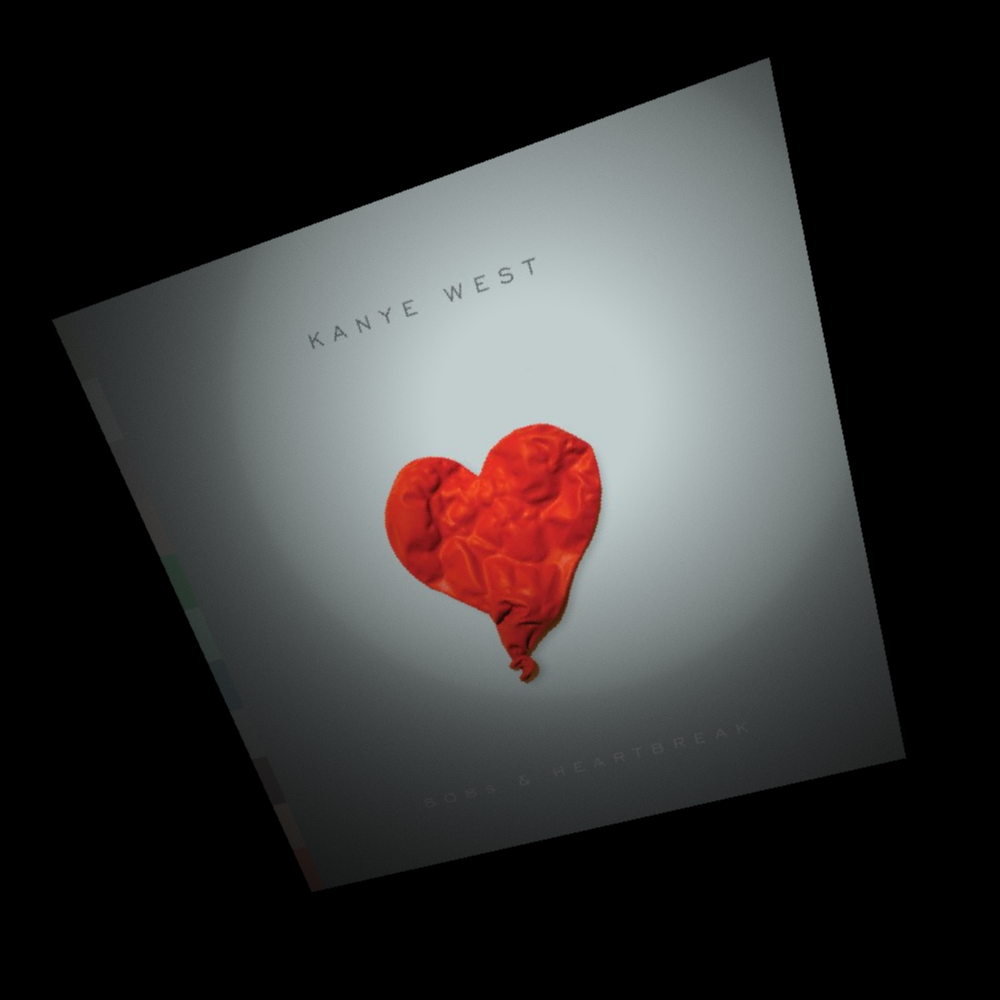

In [10]:
display(kis)